### **cuFOLIO: Portfolio Optimization on GPU**

This tutorial explores portfolio optimization techniques using the `cuOpt` solver on GPU. 

### **Introduction**
This tutorial explores **GPU-accelerated portfolio optimization** using **Conditional Value at Risk (CVaR)**. It demonstrates how to construct the **Efficient Frontier**, compare **CPU vs. GPU optimization**, and analyze **portfolio performance across market regimes**. The goal is to optimize asset allocation while managing risk efficiently.

### **Steps Covered**
1. **Portfolio Optimization Setup** – Import necessary libraries and configure solver settings.  
2. **Solving Optimization on GPU** – Define optimization parameters and execute on GPU.  
3. **Constructing the Efficient Frontier** – Visualize optimal risk-return portfolios.  
4. **Comparing CPU and GPU Performance** – Evaluate performance solving optimization problem on GPU vs CPU.

#### **Importing Required Libraries**

Before diving into portfolio optimization, we need to import the necessary libraries for optimization, data handling, visualization, and backtesting.

In [ ]:
# Install dependencies
!pip install -q -r requirements.txt
# If cuML is not installed
# !pip install --extra-index-url https://pypi.nvidia.com "cuml-cu12==25.4.*"

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

# Optimization and numerical computation libraries
from cufolio import cvar_optimizer, cvar_utils
import cvxpy as cp
from cuopt import linear_programming

#### **0. Formulation of the Optimization Problem**

Mean-CVaR optimization can be formulated as follows:

\begin{align}
\text{max: } &\mu^\top \mathbf{w} - \lambda_{risk}\left(t + \frac{1}{1-\alpha}\mathbf{p}^\top \mathbf{u}\right)\\
\text{subject to: } & \mathbf{1}^\top \mathbf{w} = 1\\
&\mathbf{u} \geq -R^\top \mathbf{w} - t\\
& \mathbf{w}^{\min} \leq \mathbf{w} \leq \mathbf{w}^{\max}, c^{\min} \leq c \leq c^{\max},\\
& L= \Vert \mathbf{w} \Vert_1 \leq L^{tar}
\end{align}

All problem-related constants in the objective and constraints should be included in `cvar_params`. 

##### Additional Supported Constraints
We support two additional types of constraints:

1. **CVaR Limit** – Set a strict upper bound on the Conditional Value-at-Risk (CVaR).
   - **How to use:** Specify `cvar_limit` in `cvar_params`.

2. **Turnover Constraint** – Restrict portfolio turnover by limiting deviations from an existing portfolio.
   - **How to use:** Provide an existing portfolio as a `Portfolio` object and set `T_tar` in `cvar_params`.

#### **1. Instantiate Parameters and Optimizer Objects**

In this section, we define the parameters for Conditional Value-at-Risk (CVaR) optimization and initialize the optimizer.

##### 1.1 Define CVaR Parameters

The `CVaR_Parameters` object encapsulates key constraints and settings for portfolio optimization, ensuring risk-aware allocation.

**Parameters:**

- **Portfolio Constraints:**
  - `w_min`, `w_max`: Minimum and maximum asset weights.
  - `c_min`, `c_max`: Minimum and maximum cash holdings.
  - `L_tar`: Leverage constraint, restricting the total long/short positions in the portfolio.

- **Risk Constraints:**
  - `risk_aversion`: Penalization factor for risk, controlling the trade-off between return and risk (higher values prioritize lower risk).
  - `confidence`: The percentile (e.g., 95% or 99%) beyond which the average loss is computed. 
  - `num_scen`: Number of simulated return scenarios.

- **Optional Constraints:**
  - `T_tar`: Turnover constraint, restricting how much the portfolio deviates from an existing allocation.
  - `cvar_limit`: Strict constraint on Conditional Value-at-Risk (CVaR).

- **Fitting Method:**
  - `fit_type`: Determines how return distributions are estimated:
    - `'kde'` (Kernel Density Estimation) for non-parametric return modeling.
    - `'no_fit'` to use historical return data directly.

In [2]:
# Define CVaR optimization parameters
cvar_params = cvar_optimizer.CVaR_Parameters(
    w_min=-0.3,         # Minimum asset weight allocation
    w_max=0.8,          # Maximum asset weight allocation
    c_min=0.1,          # Minimum cash holdings
    c_max=0.4,          # Maximum cash holdings
    L_tar=1.6,          # Leverage constraint (total long/short weight change)
    T_tar=None,         # Turnover constraint (limits portfolio deviation from an existing allocation)
    cvar_limit=None,    # Maximum allowed Conditional Value-at-Risk (CVaR)
    risk_aversion=0.5,  # Change to risk aversion levels (0 = maximize return subject to risk constraints)
    confidence=0.95,    # Confidence level for CVaR calculation
    num_scen=10000,     # Number of return scenarios to simulate
    fit_type="kde",     # Return distribution estimation method ('kde' for kernel density estimation, 'no_fit' for historical returns)
)

##### 1.2 Load Returns Data  

We first construct a **returns dictionary**, which contains essential market data and scenario definitions.  

**Key Components:**  

- **Return Type (`return_type`)**  
  - Specifies the method for calculating returns.  
  - `'LOG'`: Log-returns, commonly used for equities and FX.  

- **Historical Dataset (`dataset_directory`)**  
  - CSV file containing adjusted closing prices for selected assets to compute historical return.
  
- **Regime Information (`regime_dict`)**  
  - Defines the market regime based on a specified time range.  
  - Helps analyze portfolio behavior under different market conditions.  

- **Scenario Modeling**  
  - Returns data can be **historical** (using past market data) or **simulated** (via KDE).  
  - The `device` parameter determines whether to compute the return distribution on **CPU** or **GPU**.  

We now select a dataset and compute returns using `calculate_returns()`, specifying the desired time range and computational device.  


In [3]:
# Select dataset and regime information
dataset_name = "sp500"
dataset_directory = f"../data/stock_data/{dataset_name}.csv"

# Define return type and regime period
"""
# If you want to analyze different market conditions, you can use the following predefined periods:
scenarios = {
    'pre_crisis': ('2005-01-01', '2007-10-01'),
    'crisis': ('2007-10-01', '2009-04-01'),
    'post_crisis': ('2009-06-30', '2014-06-30'),
    'oil_price_crash': ('2014-06-01', '2016-03-01'),
    'FAANG_surge': ('2015-01-01', '2021-01-01'),
    'covid': ('2020-01-01', '2023-01-01'),
    'recent': ('2022-01-01', '2024-07-01')
}
"""
return_type = "LOG"
regime_dict = {"name": "recent", "range": ("2022-01-04", "2024-07-07")}

# Compute returns dictionary (set device for KDE computation)
returns_dict = cvar_utils.calculate_returns(
    dataset_directory, regime_dict, return_type, cvar_params, device="GPU"
)

##### 1.3 Instantiate the CVaR Optimizer
Finally, we create the CVaR optimizer object, which integrates the computed return data and optimization parameters.

In [4]:
# Instantiate CVaR optimization problem
example_cvar_problem = cvar_optimizer.CVaR(
    returns_dict=returns_dict, cvar_params=cvar_params
)

#### **2. Solve the Optimization Problem on GPU**

##### 2.1 Configure GPU Solver Settings and Solve the CVaR Optimization Problem on GPU

In [5]:
# Initialize solver settings
gpu_settings = linear_programming.SolverSettings()
gpu_settings.set_solver_mode(linear_programming.solver_settings.SolverMode.Stable1)
gpu_settings.set_infeasibility_detection(False)     # Disable infeasibility detection
gpu_settings.set_optimality_tolerance(1e-4)         # Define optimality tolerance (default: 1e-4)
gpu_settings.set_iteration_limit(10000)             # Set iteration limit to control convergence
gpu_settings.set_time_limit(10)                     # Set time limit for the solver to 10 seconds
gpu_settings.set_log_to_console(False)              # Disable log to console

# Solve the optimization problem using the configured GPU solver settings
gpu_result, gpu_portfolio = example_cvar_problem.solve_optimization_problem(
    device="GPU", gpu_settings=gpu_settings
)

*************************
--- GPU CVaR Results---
recent: ('2022-01-04', '2024-07-07')
Scenarios: 10000
solver time: 0.8410 seconds
IO time: 0.1386 seconds
--- Optimal Portfolio ---
Long--FICO: 0.211
Long--GE: 0.202
Short--ILMN: -0.2
Long--LLY: 0.454
Short--MTCH: -0.3
Long--NVDA: 0.212
Long--VLO: 0.019
cash: 0.4
*************************



##### 2.2 View Optimization Results

Note that CVaR will be capped at your `cvar_limit` if you specified it in `cvar_params`

In [6]:
gpu_result

regime          recent
solve time       0.841
return        0.003089
CVaR          0.027094
obj          -0.002339
dtype: object

##### 2.3 Plot the Optimized Portfolio

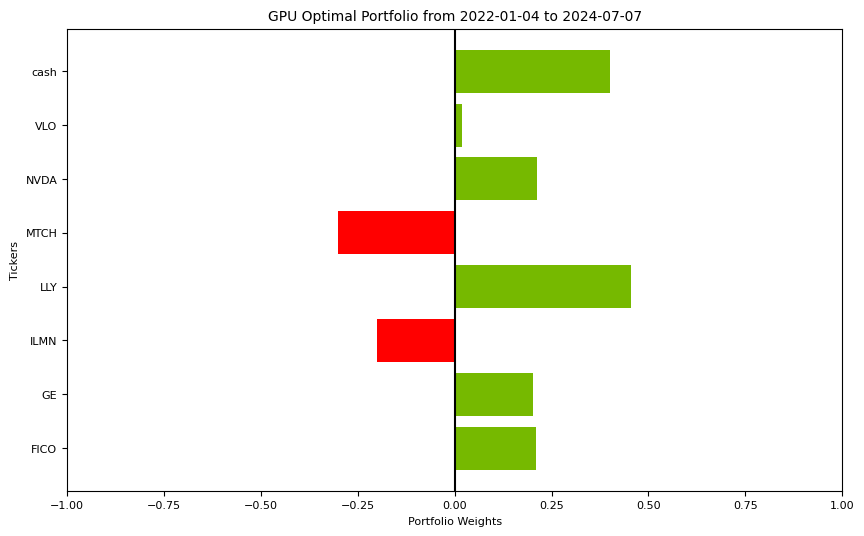

In [7]:
ax = gpu_portfolio.plot_portfolio(
    show_plot=True,
    title="GPU Optimal Portfolio from "
    + regime_dict["range"][0]
    + " to "
    + regime_dict["range"][1],
)

#### **3. Constructing the Efficient Frontier for Portfolio Optimization**

**What Is the Efficient Frontier?**

The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return.

Portfolios that lie below the efficient frontier are sub-optimal because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are sub-optimal because they have a higher level of risk for the defined rate of return.

##### 3.1 Define CVaR parameters

We redefine a set of parameters for this example.

In [8]:
cvar_params = cvar_optimizer.CVaR_Parameters(
    w_min=0,
    w_max=1,
    c_min=0,
    c_max=0,
    L_tar=1.6,
    T_tar=None,
    risk_aversion=1,
    cvar_limit=None,
    confidence=0.95,
    num_scen=10000,
    fit_type="kde",
)

##### 3.2 Prepare Market Data for Optimization 

In [9]:
dataset_name = "global_titans_proxy"
dataset_directory = f"../data/stock_data/{dataset_name}.csv"
return_type = "LOG"
regime_dict = {"name": "recent", "range": ("2022-01-04", "2024-07-01")}

returns_dict = cvar_utils.calculate_returns(
    dataset_directory, regime_dict, return_type, cvar_params
)

# Define directory for storing optimization data
cuOpt_data_directory = "cuopt_cvar"
folder_name = f"{dataset_name}-{cvar_params.fit_type}"

##### 3.3 Define Efficient Frontier Parameters
The Efficient Frontier (EF) represents optimal portfolios balancing risk and return.

**Parameters to construct efficient frontier**
- `device`: Run optimization on CPU or GPU
- `key_portfolios`: Type of the returns, e.g., 'LOG' for log-returns (used for equities, FX, ...)
- `verbose`: Whether to display annotations
- `custom_portfolios_dict` (optional): Custom portfolios to display on EF plot. Input as a dictionary
- `title`: Title of the efficient frontier plot. Will use the default title if not provided 
- `EF_plot_png_name`: The directory to save the EF plot
- `show_plot`: Display the EF plot
- `min_risk_aversion`: the lower bound for the risk aversion parameter, expressed as the exponent (power of 10) 
- `max_risk_aversion`: the upper bound for the risk aversion parameter, expressed as the exponent (power of 10) 
-  `ra_num`: number of risk_aversion values in logspace to solve the problem with


In [10]:
# We define a custom portfolio in this example
custom_portfolios_dict = {
    "NVDA-AMZN portfolio": ({"NVDA": 0.72, "AMZN": 0.18}, 0.1),
    "AAPL-MSFT portfolio": ({"AAPL": 0.29, "NKE": 0.01, "MSFT": 0.6}, 0.1),
}

# Set Efficient Frontier plot parameters
title = "EF Plot -" + dataset_name

# Create directory for results
EF_folder_name = "EF_results"
os.makedirs(EF_folder_name, exist_ok=True)

EF_result_csv_name = EF_folder_name + "/EF_results.csv"
EF_plot_png_name = EF_folder_name + "/EF_plot.png"

# Define risk aversion range
min_risk_aversion = (-3)  # loop through different levels of risk aversion, starting with 1e-3 (corresponds to high risk appetite)
max_risk_aversion = 1     # up to 1e1 = 10, corresponds to risk-averse behavior
ra_num = 30               # Number of risk aversion levels to loop through; the higher the number, the smoother the efficient frontier

##### 3.4 Run Efficient Frontier Calculation (This will take some time to run)

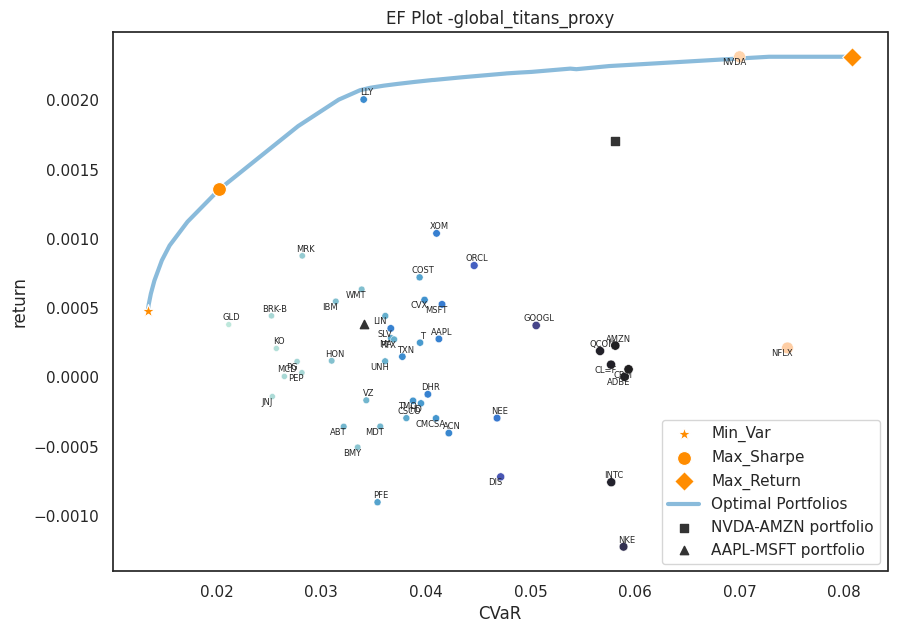

In [11]:
result_dataframe = cvar_utils.generate_efficient_frontier(
    returns_dict,
    cvar_params,
    device="GPU",
    gpu_settings=gpu_settings,
    opt_result_verbose=False,
    folder_name=None,
    custom_portfolios_dict=custom_portfolios_dict,
    title=title,
    EF_result_csv_name=EF_result_csv_name,
    EF_plot_png_name=EF_plot_png_name,
    show_plot=True,
    min_risk_aversion=min_risk_aversion,
    max_risk_aversion=max_risk_aversion,
    ra_num=ra_num,
)

#### **4. Comparing CPU and GPU Optimization Across Market Regimes** 

This section compares portfolio optimization results across **different market regimes** using **CPU and GPU**. Run with `device="BOTH"` to compare CPU and GPU performance.  

In [12]:
dataset_name_regimes = "sp500"
dataset_directory_regimes = f"../data/stock_data/{dataset_name_regimes}.csv"
return_type = "LOG"

"""
# If you want to analyze different market conditions, you can use the following predefined periods:
scenarios = {
    'pre_crisis': ('2005-01-01', '2007-10-01'),
    'crisis': ('2007-10-01', '2009-04-01'),
    'post_crisis': ('2009-06-30', '2014-06-30'),
    'oil_price_crash': ('2014-06-01', '2016-03-01'),
    'FAANG_surge': ('2015-01-01', '2021-01-01'),
    'covid': ('2020-01-01', '2023-01-01'),
    'recent': ('2022-01-01', '2024-07-01')
}
"""
# Define historical market regimes
sp500_regime_dict = {
    "pre_crisis": ("2005-01-01", "2007-10-01"),
    "crisis": ("2007-10-01", "2009-04-01")
}

cvar_params_regimes = cvar_optimizer.CVaR_Parameters(
    w_min=-0.3,
    w_max=0.8,
    c_min=0.1,
    c_max=0.4,
    L_tar=1.6,
    T_tar=None,
    cvar_limit=0.04,
    risk_aversion=0.3,
    confidence=0.95,
    num_scen=10000,
    fit_type="kde",
)

# create the folder to save the results if non-existent
regimes_folder_name = "regime_results"
os.makedirs(regimes_folder_name, exist_ok=True)

# Run both CPU and GPU (with 10k scenarios, about 2-3 mins/regime)
both_results_csv = (
    regimes_folder_name
    + f"/both_results_{dataset_name_regimes}_{cvar_params_regimes.num_scen}.csv"
)

# CPU settings
cpu_settings = {"solver": cp.CLARABEL, "verbose": False}
# cuOpt Settings
gpu_settings = linear_programming.SolverSettings()
gpu_settings.set_solver_mode(
    linear_programming.solver_settings.SolverMode.Stable1
)
gpu_settings.set_infeasibility_detection(False)
gpu_settings.set_optimality_tolerance(1e-4)
gpu_settings.set_iteration_limit(10000)
gpu_settings.set_time_limit(10)
gpu_settings.set_log_to_console(False)

# Run the optimization across all defined regimes on both CPU and GPU for performance comparison.
both_results = cvar_utils.optimize_market_regimes(
    input_file_name=dataset_directory_regimes,
    return_type=return_type,
    all_regimes=sp500_regime_dict,
    device="BOTH",
    cpu_settings=cpu_settings,
    gpu_settings=gpu_settings,
    problem_from_folder=None,
    cvar_params=cvar_params_regimes,
    results_csv_file_name=both_results_csv,
)

Solver: CLARABEL
*************************
--- CPU CVaR Results---
pre_crisis: ('2005-01-01', '2007-10-01')
Scenarios: 10000
solver time: 114.3744 seconds
--- Optimal Portfolio ---
Long--AAPL: 0.261
Short--AXON: -0.055
Short--BSX: -0.027
Long--DLR: 0.097
Long--HOLX: 0.077
Long--ILMN: 0.225
Long--ISRG: 0.093
Short--JCI: -0.139
Short--LEN: -0.14
Long--MNST: 0.392
Long--NVDA: 0.05
Long--SBAC: 0.045
cash: 0.122
*************************

*************************
--- GPU CVaR Results---
pre_crisis: ('2005-01-01', '2007-10-01')
Scenarios: 10000
solver time: 0.9360 seconds
IO time: 0.0648 seconds
--- Optimal Portfolio ---
Long--AAPL: 0.221
Short--AMD: -0.015
Short--AXON: -0.046
Short--BSX: -0.046
Short--DHI: -0.007
Long--DLR: 0.061
Long--HOLX: 0.093
Long--ILMN: 0.203
Long--ISRG: 0.168
Short--JCI: -0.151
Short--LEN: -0.114
Long--LKQ: 0.001
Long--MNST: 0.381
Long--NVDA: 0.062
Short--PHM: -0.013
Long--SBAC: 0.018
cash: 0.182
*************************

Solver: CLARABEL
*************************
